In [70]:
#imports
import pandas as pd
import numpy as np
import pickle

#!pip install imbalanced-learn
#!pip install nltk
#!pip install langdetect

import warnings
warnings.filterwarnings("ignore")

#from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import StackingClassifier

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler

from copy import deepcopy

# integrating our preprocessing into a pipeline
from sklearn.base import BaseEstimator, TransformerMixin


import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet
from nltk import pos_tag

from langdetect import detect_langs
import string # 
import re # regex
import itertools # flattening

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet = True)
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

# tensorflow?

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
%matplotlib inline

[nltk_data] Downloading package words to /Users/Viki/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Viki/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/Viki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Viki/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
### Data Exploration

In [52]:
df = pd.read_csv('data/train.csv')
#df['comment_text'].iloc[0]
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [4]:
df.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [5]:
#df.dropna(inplace = True)

In [ ]:
# Calculate the average length of each comment
average_lengths = df['comment_text'].apply(lambda x: len(x))

# Display the results in a bar chart with 50 bins
plt.hist(average_lengths, bins=50)
plt.xlabel('Comment Length')
plt.ylabel('Number of Comments')
plt.title('Average Length of Comments')
plt.show()

In [7]:
# inspecting toxic comments
toxic = df.loc[df['toxic'] == 1]
toxic.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [10]:
avg_toxic_length = toxic['comment_text'].apply(len).mean()
avg_toxic_length

295.24604420034

In [11]:
# inspecting toxic comments
normal = df.loc[df['toxic'] == 0]
normal.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [13]:
avg_normal_length = normal['comment_text'].apply(len).mean()
avg_normal_length

404.5493391185012

In [14]:
# inspecting a selected comment
print(df.iloc[12]['comment_text'])

Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...


In [15]:
# inspecting a selected comment
print(df.iloc[0]['comment_text'])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [75]:
# checking the toxicity for the selected comment
print(df.iloc[12][df.columns[2:]])

toxic            1
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 12, dtype: object


In [76]:
# checking value_counts for each column
values = df.iloc[:,2:].sum()
values

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [16]:
pattern = r'[^\x00-\x7F]'
non_english = df['comment_text'].str.contains(pattern)

In [24]:
non_english_rows = df[non_english]
non_english_rows.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
10,0005300084f90edc,"""\nFair use rationale for Image:Wonju.jpg\n\nT...",0,0,0,0,0,0
37,0015f4aa35ebe9b5,pretty much everyone from warren county/surrou...,0,0,0,0,0,0
50,001d8e7be417776a,"""\n\nBI, you said you wanted to talk\n\nAt the...",0,0,0,0,0,0
66,00290e2a171dd073,"""\n - NeilN's bang on - You aren't being haras...",0,0,0,0,0,0


In [27]:
# inspecting a selected comment
print(df.iloc[50]['comment_text'])

"

BI, you said you wanted to talk

At the bottom of the lead section you have written:

""Its promoter speculated in 1994 that the skyhook concept could be cost competitive with what is realistically thought to be achievable using a space elevator, but the skyhook is not competitive with other rotating tether concepts. In addition, the rotating skyhook is in fact deemed ""not engineeringly feasible using presently available materials"".""

Regarding:  In addition, the rotating skyhook is in fact deemed ""not engineeringly feasible using presently available materials""

That statement appears to come from Ref [3] on page 10.  The full quote is

""If the mass of the tether alone started to exceed 200 times the mass of the payload,
then that was an indication the particular scenario being considered was not engineeringly
feasible using presently available materials, although the application might become feasible in
the near future as better materials become available with higher tensile 

In [21]:
pattern = r'http?://[^\s]+'
http_links = df['comment_text'].str.contains(pattern)

In [22]:
http_link_rows = df[http_links]
http_link_rows

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
22,000c0dfd995809fa,"""\n\n Snowflakes are NOT always symmetrical! \...",0,0,0,0,0,0
33,001363e1dbe91225,I was able to post the above list so quickly b...,0,0,0,0,0,0
73,002c9cccf2f1d05b,"""\n Ambiguous ? \nSo Mabuska Irish can mean mo...",0,0,0,0,0,0
101,003fa0c68deca750,Check the following websites:\n\nhttp://www.ir...,0,0,0,0,0,0
117,004d912a00f79c89,Also see this if you cant trust Murkoth Ramunn...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159344,fc4f3715277260f3,jprw \n\nplease visit this link to better unde...,0,0,0,0,0,0
159375,fca6db97dde470bc,"""\n\nHello\nI keep getting a message from anot...",0,0,0,0,0,0
159417,fd5773ec2e4bcf3a,"""\n\n News suppressed on Wikipedia http://rexc...",0,0,0,0,0,0
159418,fd58d3a74b75da85,"""From their website:\n""""In 1965 Rudolf Schenke...",0,0,0,0,0,0


In [23]:
# inspecting a selected comment with http link
print(df.iloc[159417]['comment_text'])

"

 News suppressed on Wikipedia http://rexcurry.net/wikipedialies.html 

RexCurry.net is the historian who made the following discoveries covered elsewhere and on Wikipedia:

1. The USA’s first Pledge used a straight-arm salute and it was the origin of the salute of the monstrous National Socialist German Workers' Party (Nazis).  It was not an ancient Roman salute.  http://rexcurry.net/pledgesalute.html

2. The Pledge began with a military salute that then stretched outward toward the flag. Historic photographs are at http://rexcurry.net/pledge2.html and at http://rexcurry.net/pledge_military.html   Due to the way that both gestures were used, the military salute led to the Nazi salute. The Nazi salute is an extended military salute. http://rexcurry.net/book1a1contents-pledge.html

3. The Pledge’s creator was a self-proclaimed socialist in the nationalism movement in the USA and his dogma influenced socialists in Germany, and his Pledge was the origin of their salute. ""Nazi"" means "

### Preprocessing

In [43]:
# converting the comment text to lowercase
df['comment_text'] = df['comment_text'].str.lower()


In [53]:
# Define the function to remove non-English characters
import re
# remove any characters that are not english
regex = re.compile('[^A-Za-z0-9]+')
def remove_non_english(string):
    return regex.sub(' ', string)

# Use the apply method to apply the remove_non_english function to each value in the specified column
df['comment_text'] = df['comment_text'].apply(remove_non_english)

In [54]:
# Remove the links using the apply method
df['comment_text'] = df['comment_text'].apply(lambda x: re.sub(r'https?:\S+', '', x))

In [55]:
# tokenizing
pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(pattern)
df['comment'] = df['comment_text'].apply(tokenizer.tokenize)

In [47]:
# removing stopwords
words = ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaa', 'aaaaaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaa'\
        'ƒüesareviƒá','aaaaaaaaaah','aaaaaaw','aaaaah','aaaah','aaaawwww','aaages','aaaghh','aaahhh','aaahs', 'wikipedia','길자비','길잡이','날짐승','날찜승','맛있다','잡아야','조선인민군', '척뉴넘','칠지도']
stopwords = stopwords.words('english')
# adding punctuations to stopwords
stopwords += list(string.punctuation) 
stopwords += words

def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list if token not in stopwords]
    return stopwords_removed

In [48]:
df['comment_clean'] = df['comment'].apply(remove_stopwords)

In [49]:
# frequency Distribution
df['comment_clean'].explode()

0         explanation
0               edits
0                made
0            username
0            hardcore
             ...     
159570             go
159570           away
159570        instead
159570        helping
159570        rewrite
Name: comment_clean, Length: 5600233, dtype: object

In [318]:

# def visualize_top_10(freq_dist, title):
    
#     # extract data from plotting
#     top_10 = list(zip(*freq_dist.most_common(10)))
#     tokens = top_10[0]
#     counts = top_10[1]
    
#     # creating plot
#     fig, ax = plt.subplots()
#     ax.bar(tokens, counts)
    
#     # customize plot appearance
#     ax.set_title(title)
#     ax.set_ylabel("Count")
#     ax.yaxis.set_major_locator(MaxNLocator(integer = True))
#     ax.tick_params(axis = "x", rotation = 90)

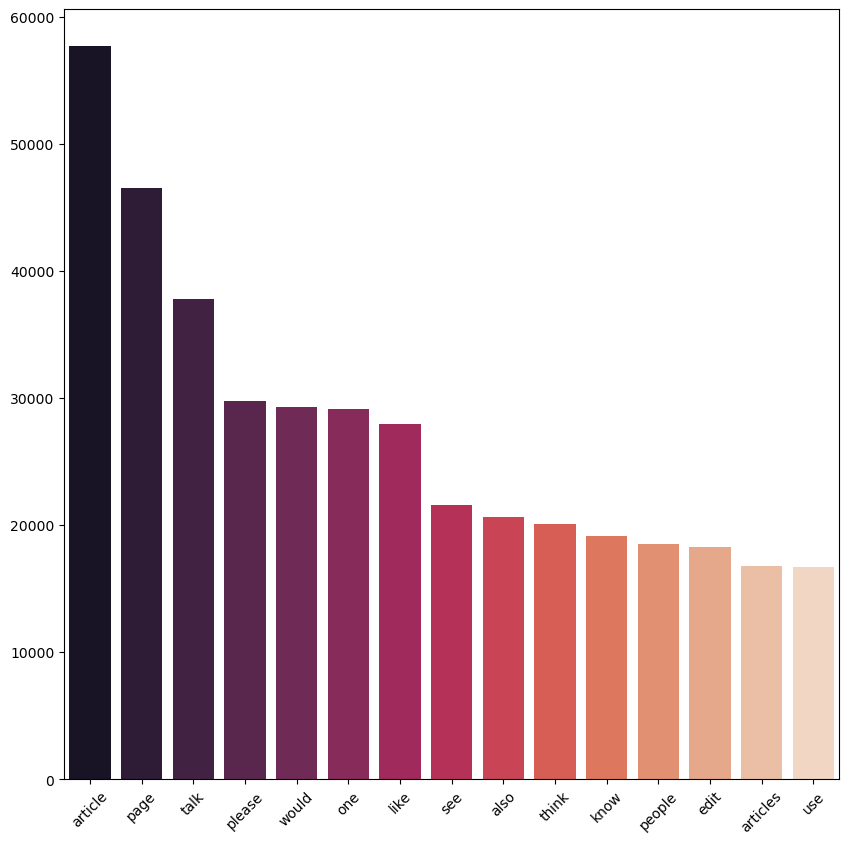

In [35]:
# visualize frequency distiribution of full dataset
freq_dist = FreqDist(df["comment_clean"].explode())

# plot the top 10 words
#visualize_top_10(freq_dist, "Top 10 Word Frequency for Full Dataset")
#plt.figure(figsize=(10,10))
#freq_dist.plot(20);
fig, ax = plt.subplots(figsize = (10, 10))
top_20 = list(freq_dist.most_common(15))
labels = [i[0] for i in top_20]
values = [i[1] for i in top_20]
sns.barplot(x = labels, y = values, palette = 'rocket', ax=ax)
plt.xticks(rotation=45);
plt.xlabel('Top 20 Words in the Dataset')
plt.ylabel('Count')
plt.title('Words')

In [36]:
toxic = df[df['toxic'] == 1]

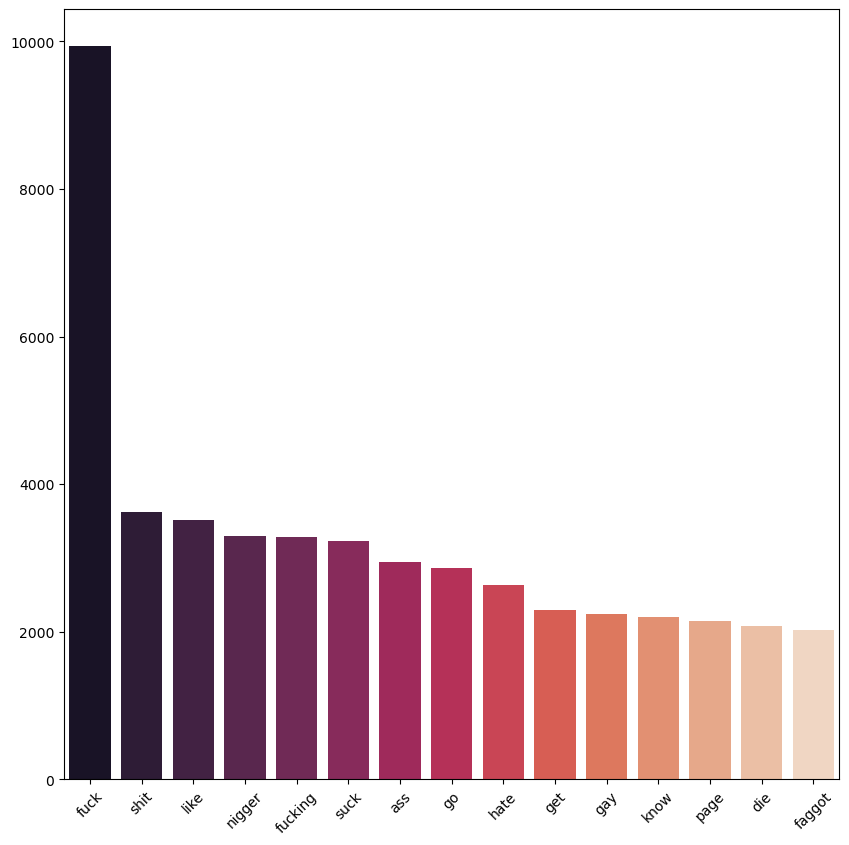

In [37]:
# visualize frequency distiribution of toxic dataset
freq_dist_toxic = FreqDist(toxic['comment_clean'].explode())

# plot the top 10 words
#visualize_top_10(freq_dist, "Top 10 Word Frequency for Full Dataset")
#plt.figure(figsize=(10,10))
#freq_dist.plot(20);

fig, ax = plt.subplots(figsize = (10, 10))
top_20 = list(freq_dist_toxic.most_common(15))
labels = [i[0] for i in top_20]
values = [i[1] for i in top_20]
sns.barplot(x = labels, y = values, palette = 'rocket' , ax=ax)
plt.xticks(rotation=45);
plt.xlabel('Top 20 Toxic Words')
plt.ylabel('Count')
plt.title('Words')

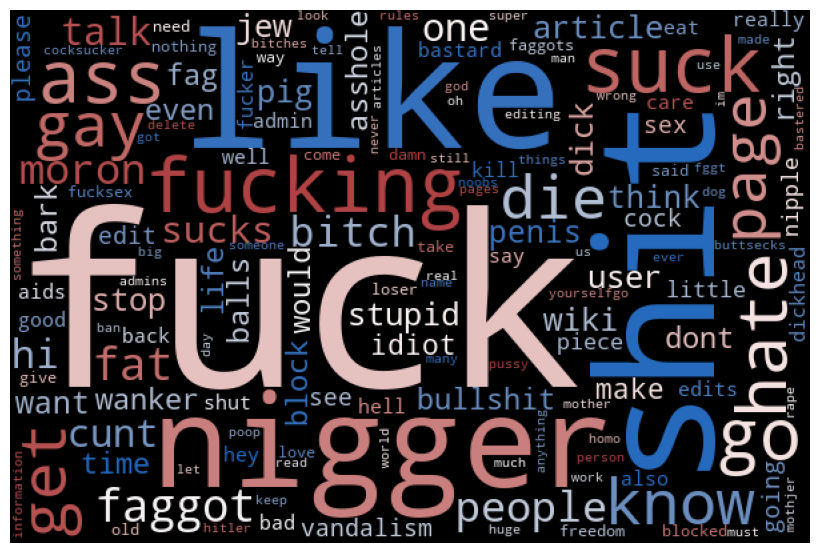

In [38]:
# creating wordCloud of most frequent toxic words
wordcloud = WordCloud(width = 600, height = 400,
                colormap="vlag", background_color ='black',
                min_font_size = 10, random_state = 30).generate_from_frequencies(freq_dist_toxic)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [39]:
# removing numeric characters with regex
df['comment_clean'] = df['comment_clean'].apply(lambda x: x if not isinstance(x, str) else x.replace(r'\d', ''))

In [56]:
stop_words = stopwords.words('english')
# adding punctuations to stopwords
stop_words += list(string.punctuation)

In [81]:
# tokenization and stemming function
snowball_stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    tok_doc = [snowball_stemmer.stem(token.lower()) for token in tokens]
    return tok_doc

In [82]:
# stemming stopwords
stemmed_stopwords = [snowball_stemmer.stem(word) for word in stop_words]

### Preprocessing

In [59]:
#targets= ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
X = df['comment_text']
y = df['toxic']

In [60]:
# train, test, validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

### Model1 - MultinomialNB - base model

In [381]:
#TfidfTransformer??

In [390]:
# initialize the countVectorizer
#tfidf = TfidfVectorizer(stop_words = stemmed_stopwords, tokenizer = stem_and_tokenize)

In [369]:
# X_train_stem = tfidf.fit_transform(X_train)
# X_val_stem = tfidf.fit_transform(X_val)
# X_test_stem = tfidf.transform(X_test)

In [61]:
# checking the original imbalance
class_priors = y_train.value_counts()/y_train.shape[0]
class_priors

0    0.904126
1    0.095874
Name: toxic, dtype: float64

In [382]:
pipe1 = Pipeline([('countvec', CountVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize)),('tranf', TfidfTransformer()),
                 ('multinb', MultinomialNB())])

In [383]:
pipe1.fit(X_train, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                ('tranf', TfidfTransformer()), ('multinb', MultinomialNB())])

In [384]:
pipe1.score(X_test,y_test)

0.9216669277769074

In [385]:
y_pred = pipe1.predict(X_test)

In [409]:
y_pred_proba = pipe1.predict_proba(X_test)[:,1]

In [410]:
y_pred_proba

array([0.00170682, 0.00092006, 0.01569012, ..., 0.00196667, 0.00061353,
       0.00077207])

In [425]:
model1 = classification_report(y_test, y_pred)
print(model1)

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     28856
           1       0.54      0.83      0.66      3059

    accuracy                           0.92     31915
   macro avg       0.76      0.88      0.80     31915
weighted avg       0.94      0.92      0.92     31915



In [413]:
roc_auc_score(y_test, y_pred_proba)

0.8873885664003913

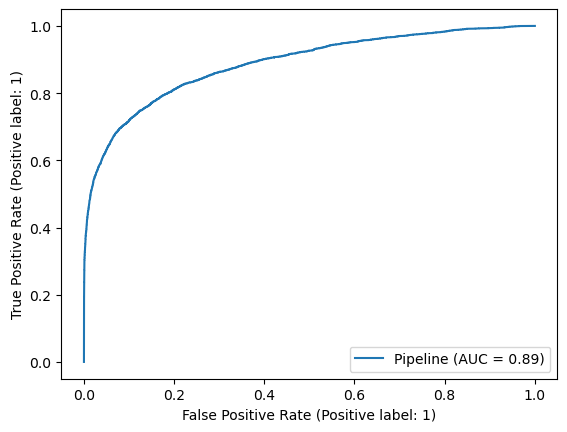

In [414]:
#plot ROC Curve
RocCurveDisplay.from_estimator(pipe1, X_test, y_test)

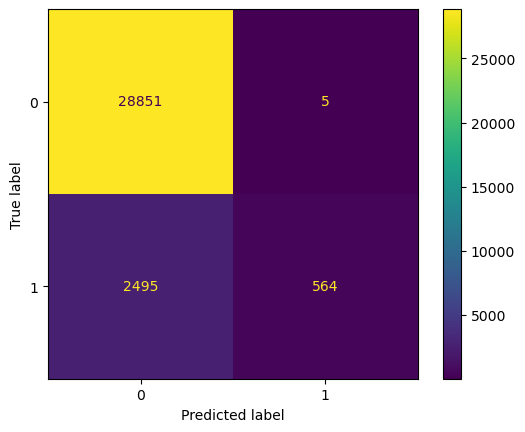

In [389]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe1, X_test, y_test);

### Model2 - MultinomialNB with SMOTE

In [ ]:
# adding SMOTE for the baseline model

In [391]:
pipe2 = Pipeline([('countvec', CountVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize)),('tranf', TfidfTransformer()),
                 ('smote', SMOTE()),
                 ('multinb', MultinomialNB())])

In [392]:
pipe2.fit(X_train, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                ('tranf', TfidfTransformer()), ('smote', SMOTE()),
                ('multinb', MultinomialNB())])

In [393]:
pipe2.score(X_test,y_test)

0.923985586714711

In [394]:
y_pred = pipe2.predict(X_test)

In [415]:
y_pred_proba = pipe2.predict_proba(X_test)[:,1]

In [424]:
model2 = classification_report(y_test, y_pred)
print(model2)

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     28856
           1       0.54      0.83      0.66      3059

    accuracy                           0.92     31915
   macro avg       0.76      0.88      0.80     31915
weighted avg       0.94      0.92      0.92     31915



In [416]:
roc_auc_score(y_test, y_pred_proba)

0.946671483828845

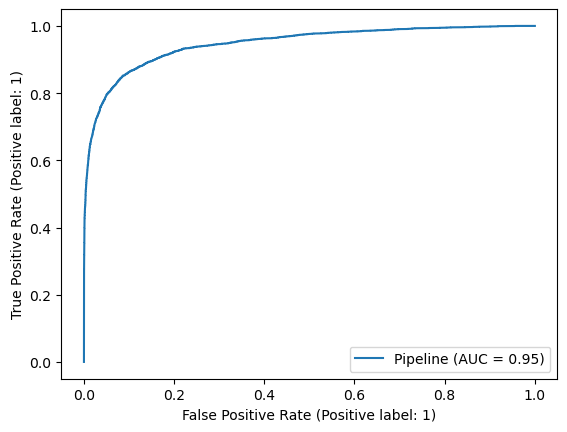

In [397]:
#plot ROC Curve
RocCurveDisplay.from_estimator(pipe2, X_test, y_test)

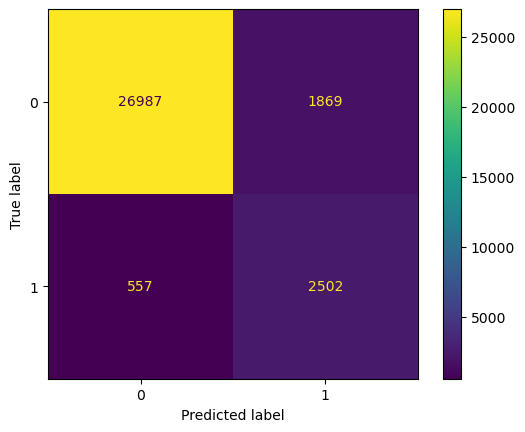

In [398]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe2, X_test, y_test);

In the next model I will run a grid search for the SMOTEd multinomialNB model.

### Model2b - MultinomialNB - best params

In [399]:
# gridsearch for multinomialNB
param_grid = {
    'countvec__ngram_range': [(1, 1), (1, 2), (1,3)],
    'multinb__alpha': [1, 1e-1, 1e-2, 0.5, 10],
    'multinb__fit_prior': [True, False]
}

clf = GridSearchCV(estimator = pipe2, param_grid = param_grid, cv=5, scoring='recall', n_jobs=-1)

In [400]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvec',
                                        CountVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'our',
                                                                    'ourselv',
                                                                    'you',
                                                                    "you'r",
                                                                    "you'v",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'your',
                                                                    'yourself',
                                                                    'yourselv',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    'she',
                                                                    'her',
                                                                    'her',
                                                                    'herself',
                                                                    'it', 'it',
                                                                    'it',
                                                                    'itself', ...],
                                                        tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                                       ('tranf', TfidfTransformer()),
                                       ('smote', SMOTE()),
                                       ('multinb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'countvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'multinb__alpha': [1, 0.1, 0.01, 0.5, 10],
                         'multinb__fit_prior': [True, False]},
             scoring='recall')

In [401]:
clf.best_params_

{'countvec__ngram_range': (1, 1),
 'multinb__alpha': 0.5,
 'multinb__fit_prior': False}

In [ ]:
CountVectorizer??

In [402]:
pipe2b = Pipeline([('countvec', CountVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize, )),('tranf', TfidfTransformer()),
                 ('smote', SMOTE()),
                 ('multinb', MultinomialNB(alpha = 0.5,
                                           fit_prior = False))])

In [403]:
pipe2b.fit(X_train, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                ('tranf', TfidfTransformer()), ('smote', SMOTE()),
                ('multinb', MultinomialNB(alpha=0.5, fit_prior=False))])

In [417]:
pipe2b.score(X_test,y_test)

0.9164029453235156

In [418]:
y_pred = pipe2b.predict(X_test)

In [419]:
y_pred_proba = pipe2b.predict_proba(X_test)[:,1]

In [420]:
model2b = classification_report(y_test, y_pred)
print(model2b)

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     28856
           1       0.54      0.83      0.66      3059

    accuracy                           0.92     31915
   macro avg       0.76      0.88      0.80     31915
weighted avg       0.94      0.92      0.92     31915



In [421]:
roc_auc_score(y_test, y_pred_proba)

0.9465545364961323

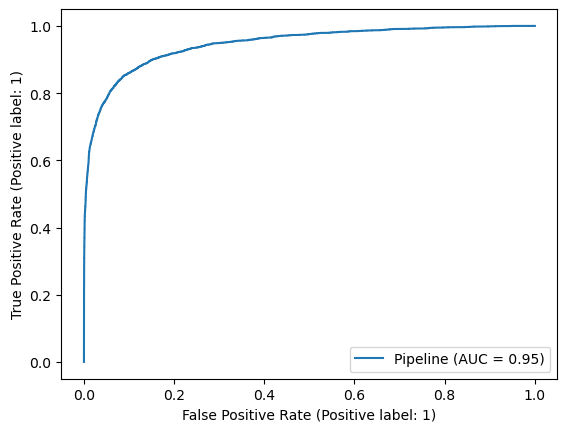

In [426]:
#plot ROC Curve
RocCurveDisplay.from_estimator(pipe2b, X_test, y_test)

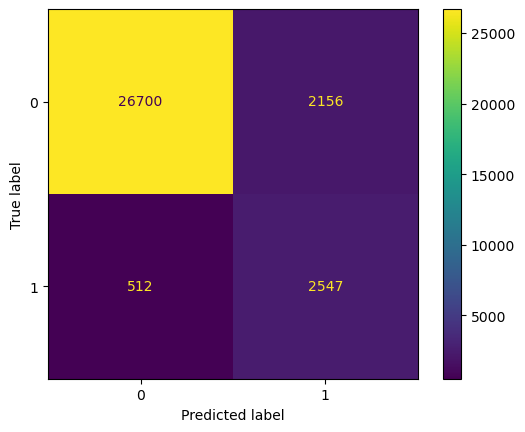

In [423]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe2b, X_test, y_test);

Running the model with the best params returned by the gridSearchCV didn't change the scores. It only made changes to the number of false negatives and false positives.

### Model3 - MultinomialNB - best params - TfidfVectorizer

In [515]:
pipe3 = Pipeline([('tfidf', TfidfVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize)),
                 ('tranf', TfidfTransformer()),
                 ('smote', SMOTE()),
                 ('multinb', MultinomialNB(alpha = 0.5,
                                           fit_prior = False))])

In [516]:
pipe3.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                ('tranf', TfidfTransformer()), ('smote', SMOTE()),
                ('multinb', MultinomialNB(alpha=0.5, fit_prior=False))])

In [517]:
pipe3.score(X_test,y_test)

0.9071283095723014

In [518]:
y_pred = pipe3.predict(X_test)
y_pred_proba = pipe3.predict_proba(X_test)[:,1]

In [519]:
model3 = classification_report(y_test, y_pred)
print(model3)

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     28856
           1       0.51      0.82      0.63      3059

    accuracy                           0.91     31915
   macro avg       0.74      0.87      0.79     31915
weighted avg       0.93      0.91      0.92     31915



In [520]:
roc_auc_score(y_test, y_pred_proba)

0.9396313291697077

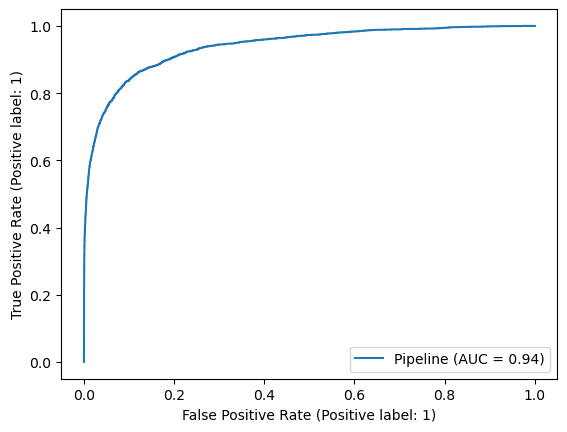

In [521]:
#plot ROC Curve
RocCurveDisplay.from_estimator(pipe3, X_test, y_test)

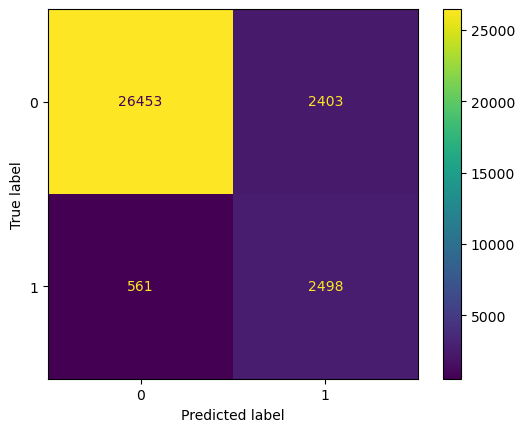

In [522]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe3, X_test, y_test);

This model with the TfidfVectorizer performed almost the same as the previous one with the countVectorizer. Compared to Model2 which had the lowest false negative (FN:557), false positive (FP:1869) pair, this model's FN rose to 561, while the FN increased to 2403. The Recall on class 1 is decreased by 1% to 82%, the F1 score fell to 63%, from 66%, and the Accuracy also decreased by 1%. Lastly the AUC also decreased by 0.01.

### Model4 - RandomForest - tfidfVectorizer

In [523]:
pipe4 = Pipeline([('tfidf', TfidfVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize)),
                 ('tranf', TfidfTransformer()),
                 ('smote', SMOTE()),
                 ('forest', RandomForestClassifier())])

In [524]:
pipe4.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                ('tranf', TfidfTransformer()), ('smote', SMOTE()),
                ('forest', RandomForestClassifier())])

In [525]:
pipe4.score(X_test,y_test)

0.9492088359705467

In [526]:
y_pred = pipe4.predict(X_test)
y_pred_proba = pipe4.predict_proba(X_test)[:,1]

In [527]:
model4 = classification_report(y_test, y_pred)
print(model4)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     28856
           1       0.82      0.60      0.69      3059

    accuracy                           0.95     31915
   macro avg       0.89      0.79      0.83     31915
weighted avg       0.95      0.95      0.95     31915



In [528]:
roc_auc_score(y_test, y_pred_proba)

0.9561106221847334

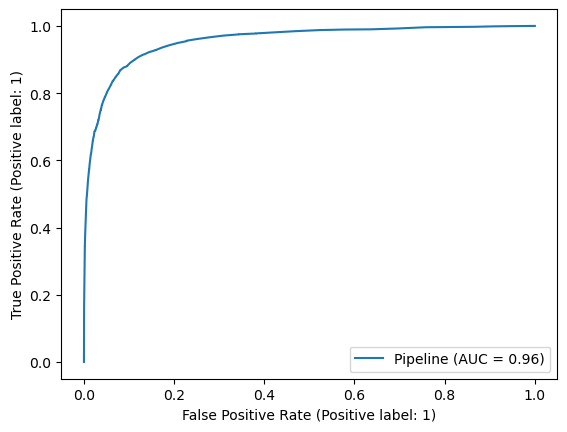

In [529]:
#plot ROC Curve
RocCurveDisplay.from_estimator(pipe4, X_test, y_test)

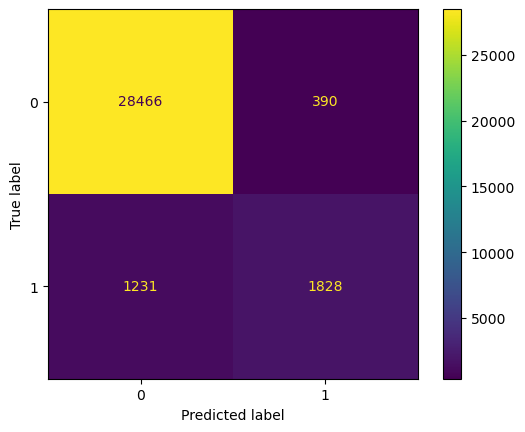

In [530]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe4, X_test, y_test);

After removing the  min_df=0.05, max_df=0.95 from the vectorizer, this RandomForest model performs way better then before.
The previously selected best model (Model2) had a FN of 557, and FP of 1869, however this model has a false negative of 1231 and false positives of 390. The recall fall back to 60%.
In the following I will try to run this model with countVectorizer and see if it is performing better then the tfidf.


### Model4b - RandomForest - CountVectorizer

In [531]:
pipe4b = Pipeline([('countvec', CountVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize)),
                 ('tranf', TfidfTransformer()),
                 ('smote', SMOTE()),
                 ('forest', RandomForestClassifier())])

In [532]:
pipe4b.fit(X_train, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                ('tranf', TfidfTransformer()), ('smote', SMOTE()),
                ('forest', RandomForestClassifier())])

In [533]:
pipe4b.score(X_test,y_test)

0.9496788344038853

In [534]:
y_pred = pipe4b.predict(X_test)
y_pred_proba = pipe4b.predict_proba(X_test)[:,1]

In [535]:
model4b = classification_report(y_test, y_pred)
print(model4b)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     28856
           1       0.84      0.59      0.69      3059

    accuracy                           0.95     31915
   macro avg       0.90      0.79      0.83     31915
weighted avg       0.95      0.95      0.95     31915



In [536]:
roc_auc_score(y_test, y_pred_proba)

0.9555854750755701

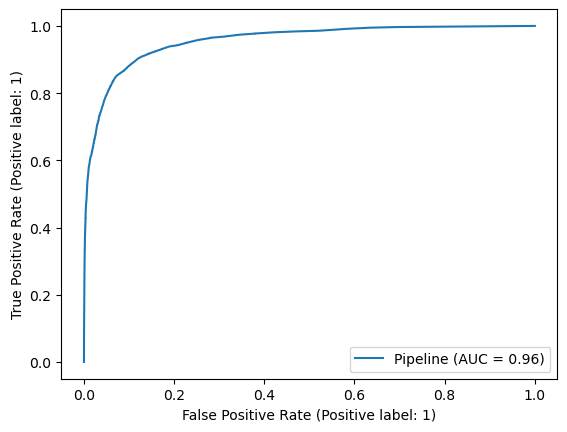

In [537]:
#plot ROC Curve
RocCurveDisplay.from_estimator(pipe4b, X_test, y_test)

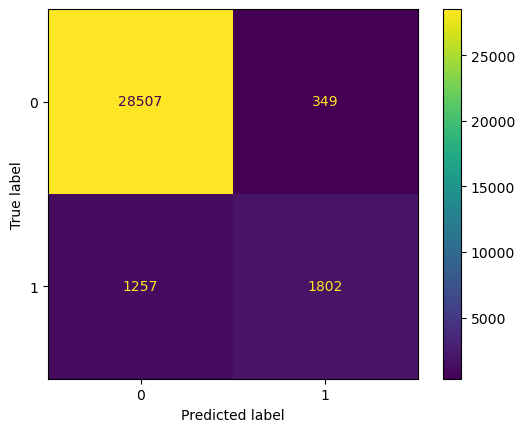

In [539]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe4b, X_test, y_test);

The number of false negatives are still high, so I will run a gridSearchCV for the RandomForest to get the optimal parameters to see if it will improve the model.

### Model5 - RanomForest - CountVectorizer - best params

In [540]:
# running a GridSearchCV for RandomForest
rf_params = param_grid = {'forest__criterion': ['gini', 'entropy'], 
                          'forest__n_estimators': [30, 50, 150], 
                          'forest__min_samples_leaf': [2, 5, 20, 50],
                         'forest__max_depth': [3, 5, 7]}

rf_grid_pipe = GridSearchCV(estimator = pipe5b, param_grid = rf_params, scoring = 'recall', cv = 3, n_jobs = -1)


In [541]:
# fitting the train
rf_grid_pipe.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvec',
                                        CountVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'our',
                                                                    'ourselv',
                                                                    'you',
                                                                    "you'r",
                                                                    "you'v",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'your',
                                                                    'yourself',
                                                                    'yourselv',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    'she',
                                                                    'her',
                                                                    'her',
                                                                    'herself',
                                                                    'it', 'it',
                                                                    'it',
                                                                    'itself', ...],
                                                        tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                                       ('tranf', TfidfTransformer()),
                                       ('smote', SMOTE()),
                                       ('forest', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'forest__criterion': ['gini', 'entropy'],
                         'forest__max_depth': [3, 5, 7],
                         'forest__min_samples_leaf': [2, 5, 20, 50],
                         'forest__n_estimators': [30, 50, 150]},
             scoring='recall')

In [542]:
# displaying the best params
rf_grid_pipe.best_params_

{'forest__criterion': 'gini',
 'forest__max_depth': 3,
 'forest__min_samples_leaf': 5,
 'forest__n_estimators': 150}

In [543]:
pipe5 = Pipeline([('countvec', CountVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize)),
                 ('tranf', TfidfTransformer()),
                 ('smote', SMOTE()),
                 ('forest', RandomForestClassifier(random_state = 43,
                                                  criterion = 'gini',
                                                  max_depth = 3,
                                                  min_samples_leaf = 5,
                                                  n_estimators = 150))])

In [544]:
pipe5.fit(X_train, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                ('tranf', TfidfTransformer()), ('smote', SMOTE()),
                ('forest',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=5,
                                        n_estimators=150, random_state=43))])

In [545]:
pipe5.score(X_test,y_test)

0.6565251449161836

In [546]:
y_pred = pipe5.predict(X_test)
y_pred_proba = pipe5.predict_proba(X_test)[:,1]

In [547]:
model5 = classification_report(y_test, y_pred)
print(model5)

              precision    recall  f1-score   support

           0       0.97      0.64      0.77     28856
           1       0.19      0.82      0.31      3059

    accuracy                           0.66     31915
   macro avg       0.58      0.73      0.54     31915
weighted avg       0.90      0.66      0.73     31915



In [548]:
roc_auc_score(y_test, y_pred_proba)

0.8305288140192334

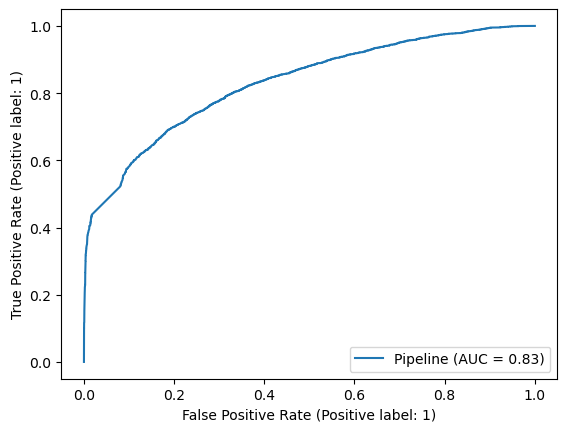

In [549]:
#plot ROC Curve
RocCurveDisplay.from_estimator(pipe5, X_test, y_test)

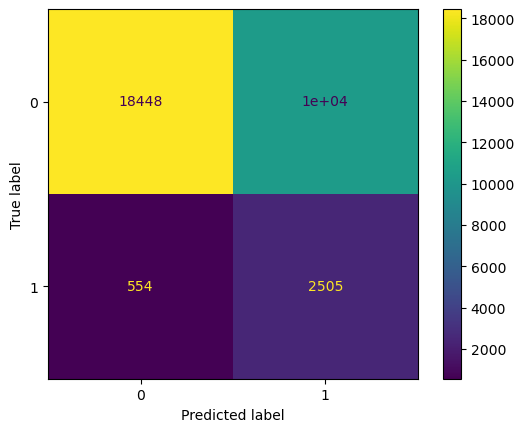

In [550]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe5, X_test, y_test);

Model5 did not perform better then Model4b. The number of FN decreased almost 50%, however the number of FP increased almost 28 fold.
In the following I will check this model's performance with RandomOverSampler instead of SMOTE.


In [551]:
pipe5b = Pipeline([('countvec', CountVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize)),
                 ('tranf', TfidfTransformer()),
                 ('over',RandomOverSampler(random_state=46)),
                 ('forest', RandomForestClassifier(random_state = 43,
                                                  criterion = 'gini',
                                                  max_depth = 3,
                                                  min_samples_leaf = 5,
                                                  n_estimators = 150))])

In [552]:
pipe5b.fit(X_train, y_train)


Pipeline(steps=[('countvec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                ('tranf', TfidfTransformer()),
                ('over', RandomOverSampler(random_state=46)),
                ('forest',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=5,
                                        n_estimators=150, random_state=43))])

In [553]:
pipe5b.score(X_test,y_test)

0.6287639041203196

In [554]:
y_pred = pipe5b.predict(X_test)
y_pred_proba = pipe5b.predict_proba(X_test)[:,1]

In [555]:
model5b = classification_report(y_test, y_pred)
print(model5b)

              precision    recall  f1-score   support

           0       0.98      0.60      0.75     28856
           1       0.19      0.86      0.31      3059

    accuracy                           0.63     31915
   macro avg       0.58      0.73      0.53     31915
weighted avg       0.90      0.63      0.70     31915



In [569]:
roc_auc_score(y_test, y_pred_proba)

0.9486387038188884

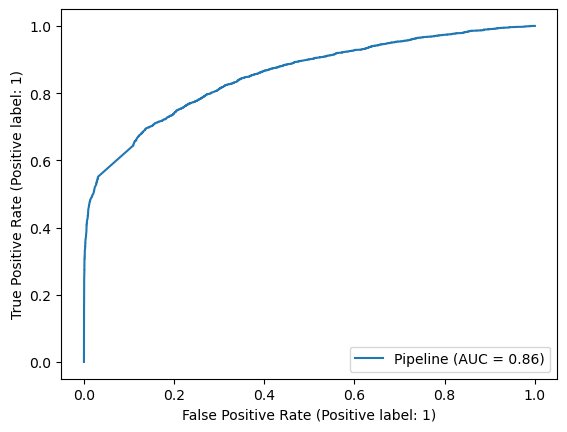

In [556]:
#plot ROC Curve
RocCurveDisplay.from_estimator(pipe5b, X_test, y_test)

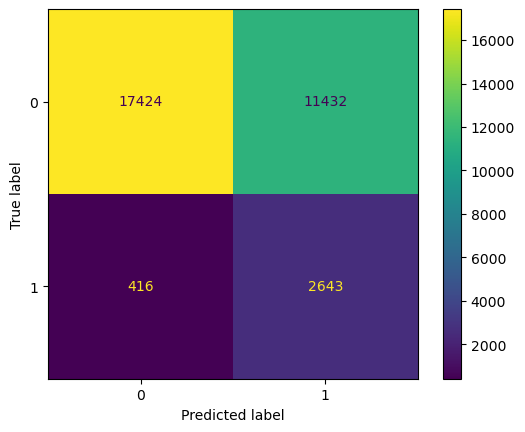

In [557]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe5b, X_test, y_test);

RandomOverSampling did not improve the the model. The recall, AUC and the FN improved, however the number of false positive increased another 1432.
I the following I will build an XGBoost model.

### Model6 - XGBoost - CountVectorizer - RandomOverSampler


In [558]:
pipe6 = Pipeline([('countvec', CountVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize)),
                 ('tranf', TfidfTransformer()),
                 ('over',RandomOverSampler(random_state= 50)),
                 ('xgb', XGBClassifier(random_state = 50))])

In [559]:
pipe6.fit(X_train, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x4a920a680>)),
                ('tranf', TfidfTransformer(...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=50, ...))])

In [560]:
pipe6.score(X_test,y_test)

0.9465141782860724

In [561]:
y_pred = pipe6.predict(X_test)
y_pred_proba = pipe6.predict_proba(X_test)[:,1]

In [562]:
model6 = classification_report(y_test, y_pred)
print(model6)


              precision    recall  f1-score   support

           0       0.98      0.96      0.97     28856
           1       0.69      0.79      0.74      3059

    accuracy                           0.95     31915
   macro avg       0.84      0.88      0.85     31915
weighted avg       0.95      0.95      0.95     31915



In [563]:
roc_auc_score(y_test, y_pred_proba)

0.9486387038188884

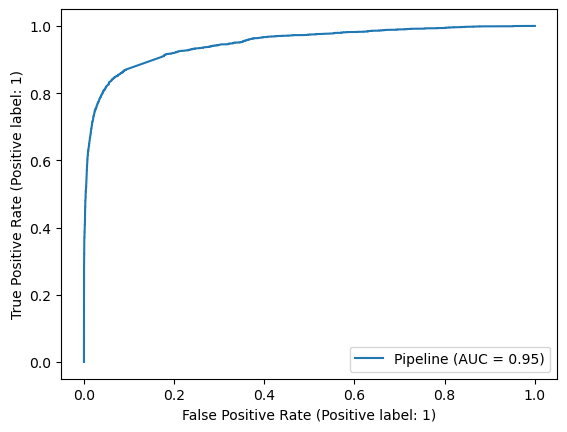

In [564]:
#plot ROC Curve
RocCurveDisplay.from_estimator(pipe6, X_test, y_test)

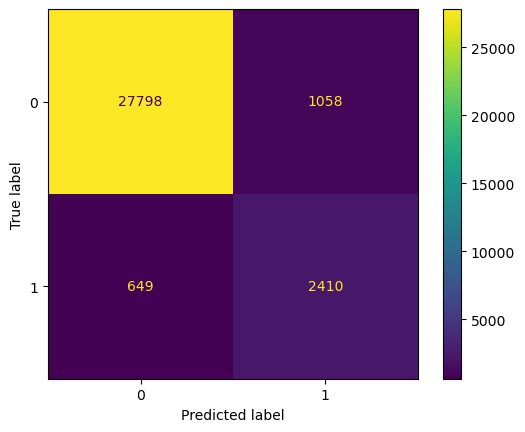

In [565]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe6, X_test, y_test);

### Model6b - XGBoost - best params - CountVectorizer - RandomOverSampler

In [566]:
# Performing a grid search for our XGBoost
xgb_params = {
    'xgb__gamma': [0.5, 1, 5],
    'xgb__learning_rate': [0.1, 0.2],
    'xgb__max_depth': [3, 5, 7],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__n_estimators': [50, 100, 150, 200]
}

xgb_grid = GridSearchCV(estimator = pipe8, param_grid = xgb_params, scoring = 'recall', cv = 3)

In [567]:
# Fitting the training data
xgb_grid.fit(X_train_proc, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvec',
                                        CountVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'our',
                                                                    'ourselv',
                                                                    'you',
                                                                    "you'r",
                                                                    "you'v",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'your',
                                                                    'yourself',
                                                                    'yourselv',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    'she',
                                                                    'her',
                                                                    'her',
                                                                    'herself',
                                                                    'it', 'it',
                                                                    'it',
                                                                    'itself', ...],
                                                        tokenizer=<function stem_and_tokenize at 0x4a920a680>)...
                                                      max_delta_step=0,
                                                      max_depth=6, max_leaves=0,
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints='()',
                                                      n_estimators=100,
                                                      n_jobs=0,
                                                      num_parallel_tree=1,
                                                      predictor='auto',
                                                      random_state=50, ...))]),
             param_grid={'xgb__gamma': [0.5, 1, 5],
                         'xgb__learning_rate': [0.1, 0.2],
                         'xgb__max_depth': [3, 5, 7],
                         'xgb__min_child_weight': [1, 5, 10],
                         'xgb__n_estimators': [50, 100, 150, 200]},
             scoring='recall')

In [568]:
# Returning the best parameters as a result of the grid search
xgb_grid.best_params_

{'xgb__gamma': 5,
 'xgb__learning_rate': 0.2,
 'xgb__max_depth': 7,
 'xgb__min_child_weight': 10,
 'xgb__n_estimators': 200}

In [83]:
# re-running the model with the best params
pipe7b = Pipeline([('countvec', CountVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize)),
                 ('tranf', TfidfTransformer()),
                 ('over',RandomOverSampler(random_state= 50)),
                 ('xgb', XGBClassifier(random_state = 51,
                                                 gamma = 5,
                                                 learning_rate = 0.2,
                                                 max_depth = 7,
                                                 min_child_weight = 10,
                                                 n_estimators = 200))])

In [84]:
pipe7b.fit(X_train, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x34ceec310>)),
                ('tranf', TfidfTransformer(...
                               feature_types=None, gamma=5, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.2,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=7, max_leaves=0, min_child_weight=10,
                               missing=nan, monotone_constraints='()',
                               n_estimators=200, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=51, ...))])

In [85]:
pipe7b.score(X_test,y_test)

0.9480808397305343

In [86]:
y_pred = pipe7b.predict(X_test)
y_pred_proba = pipe7b.predict_proba(X_test)[:,1]

In [87]:
model7b = classification_report(y_test, y_pred)
print(model7b)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     28856
           1       0.69      0.82      0.75      3059

    accuracy                           0.95     31915
   macro avg       0.84      0.89      0.86     31915
weighted avg       0.95      0.95      0.95     31915



In [88]:
roc_auc_score(y_test, y_pred_proba)

0.9595100136734236

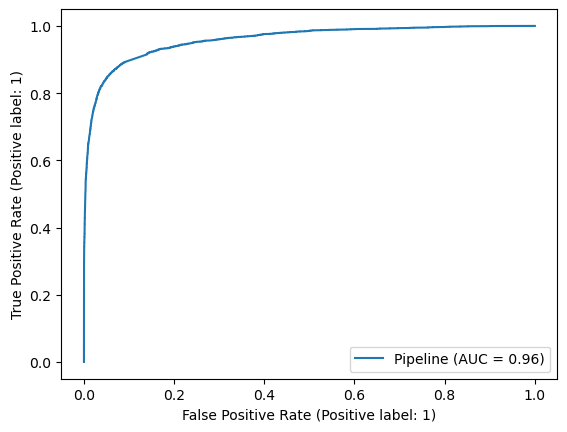

In [89]:
#plot ROC Curve
RocCurveDisplay.from_estimator(pipe7b, X_test, y_test)

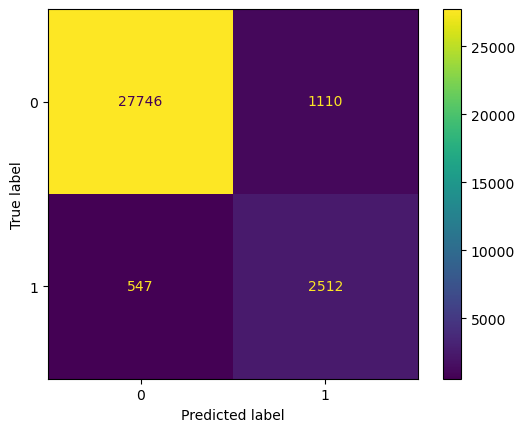

In [90]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe7b, X_test, y_test);

### Model7 - Ensemble method - Stacking

In [91]:
estimators = [
    ('multinb', MultinomialNB(alpha = 0.5,
                              fit_prior = False)),
    ('forest', RandomForestClassifier(criterion = 'gini',
                                      max_depth = 3,
                                      min_samples_leaf = 5,
                                      n_estimators = 150)),
    ('xgb', XGBClassifier(random_state = 51,
                          gamma = 5,
                          learning_rate = 0.2,
                          max_depth = 7,
                          min_child_weight = 10,
                          n_estimators = 200))
]

In [104]:
estimators = [
    ('multinb', MultinomialNB(alpha = 0.5,
                              fit_prior = False)),
    ('xgb', XGBClassifier(random_state = 51,
                          gamma = 5,
                          learning_rate = 0.2,
                          max_depth = 7,
                          min_child_weight = 10,
                          n_estimators = 200))
]

In [105]:
sr = StackingClassifier(estimators)


In [106]:
pipe7 = Pipeline([('vectorizer', TfidfVectorizer(stop_words = stemmed_stopwords,
                    tokenizer = stem_and_tokenize)),
                 ('tranf', TfidfTransformer()),
                 ('smote',SMOTE(random_state= 52)),
                 ('ens', sr)
                 ])

In [107]:
pipe7.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x34ceec310>)),
                ('tranf', TfidfTransforme...
                                                               gpu_id=None,
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=0.2,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=7,
                                                               max_leaves=None,
                                                               min_child_weight=10,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=200,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=51, ...))]))])

In [108]:
pipe7.score(X_test, y_test)

0.949772834090553

In [109]:
y_pred7 = pipe8.predict(X_test)
y_pred_proba = pipe7.predict_proba(X_test)[:,1]

In [110]:
model7 = classification_report(y_test, y_pred7)
print(model7)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     28856
           1       0.70      0.84      0.76      3059

    accuracy                           0.95     31915
   macro avg       0.84      0.90      0.87     31915
weighted avg       0.96      0.95      0.95     31915



In [111]:
roc_auc_score(y_test, y_pred_proba)

0.9651342989952794

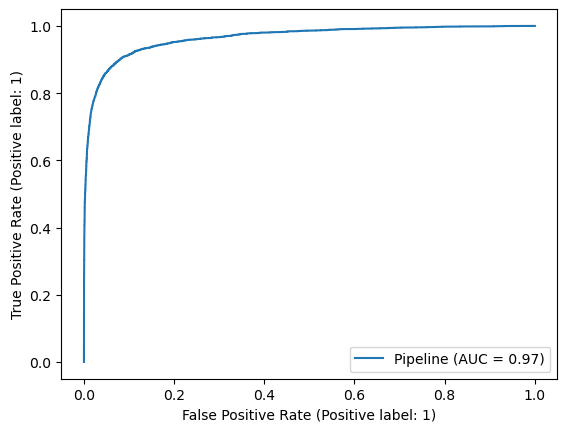

In [112]:
#plot_roc_curve(mod_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(pipe7, X_test, y_test)

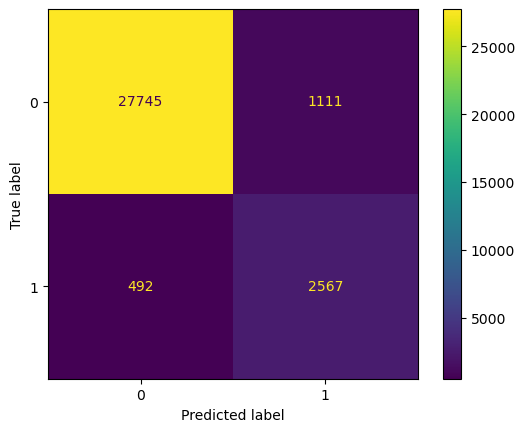

In [113]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe7, X_test, y_test);

This last ensemble model performed the best. This model combines the prediction of the MultinomialNB and the XGBoost model with best params. This Stacking model uses the tfidf vectorizer and SMOTE. The resulting model has a high recall score of 84% and an AUC of 0.97 on the test set, with relatively low numbers of false negatives (492) and false positives (1111).
Part of the reason I choose this model is becaue this model had the lowest FN - FP pair. It is important to minimize the number of false negatives, because users wouldn't be flagged for writting toxic comments, when actually they are.
This model is likely performed the well because the combination of MultinomialNB and XGBoost are able to capture a wide range of patters in the data, allowing it to make more accurate predictions than the previous models. In addition the use of tfidf vectorizer may be able to capture important information about the frequency and importance of different words in the data. SMOTE likely helped to improve the model's performance by better representing the features of the data and addressing class imbalances respectively.